In [67]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

In [68]:
device = "cuda:0"
LATENT_DIM = 64
NUM_GENERATORS = 10

In [69]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [70]:
X_train, X_test, Y_train, Y_test = data.get_dataset_distilled()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")

In [71]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=512,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [72]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentDescriminator().to(device) # Since we ony have two elements

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [73]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_BCE(m_S,torch.sigmoid(m))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_BCE(m.squeeze(),M)
        
        loss_S = loss1 + loss2 + loss3
        loss_Ae = loss5
        loss_O = loss6
        
        loss_S.backward(retain_graph=True)
        loss_Ae.backward()
        loss_O.backward()
        
        
        
        optimiser_fd.step()
        optimiser_fe.step()
        optimiser_fo.step()
        optimiser_symmetry.step()
    
        
        loss_S_closure_ += loss1.item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss6.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 227/227 [00:12<00:00, 17.66it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.4150643957212633
Symmetry Orthogonality Loss  0.31029131993782677
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.12840018893842328
Oracle loss 0.22678434573081097


100%|██████████| 227/227 [00:12<00:00, 18.51it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.10744125509248956
Symmetry Orthogonality Loss  0.04513940979862003
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00156380718580082
Oracle loss 0.02558225183234866


100%|██████████| 227/227 [00:12<00:00, 17.82it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.035414669383727504
Symmetry Orthogonality Loss  0.044509551171951885
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0003065587359117467
Oracle loss 0.006231827359843491


100%|██████████| 227/227 [00:13<00:00, 17.46it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.017097646596180974
Symmetry Orthogonality Loss  0.04408289283710955
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00013094377988079637
Oracle loss 0.0026296993265223856


100%|██████████| 227/227 [00:12<00:00, 17.54it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.009940294614513016
Symmetry Orthogonality Loss  0.04339577800836332
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.547004548051714e-05
Oracle loss 0.00140161679453516


100%|██████████| 227/227 [00:13<00:00, 17.39it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.0064987165192839595
Symmetry Orthogonality Loss  0.0431210047479243
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.960503343772246e-05
Oracle loss 0.0008645701395975434


100%|██████████| 227/227 [00:12<00:00, 17.64it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.004548777710227912
Symmetry Orthogonality Loss  0.04296241922197363
Symmetry Collapse Loss  0.0
Space Inversion Loss  7.203518032734303e-05
Oracle loss 0.0005787320687365821


100%|██████████| 227/227 [00:12<00:00, 17.63it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.00334957640696038
Symmetry Orthogonality Loss  0.04237886875999131
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5872836677303194e-05
Oracle loss 0.00041088570483205307


100%|██████████| 227/227 [00:12<00:00, 17.83it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.002524780459796378
Symmetry Orthogonality Loss  0.042317429417949415
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.991274581357066e-05
Oracle loss 0.0002991815082501161


100%|██████████| 227/227 [00:12<00:00, 18.03it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.0019796402239761752
Symmetry Orthogonality Loss  0.041914184942907176
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.256244913924901e-05
Oracle loss 0.0002292002280604808


100%|██████████| 227/227 [00:12<00:00, 18.77it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.0015631297163230403
Symmetry Orthogonality Loss  0.041480558050492784
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.182245402020584e-05
Oracle loss 0.00017591054059102484


100%|██████████| 227/227 [00:12<00:00, 18.27it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.001273699359412383
Symmetry Orthogonality Loss  0.041310555084161295
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.0979528741417186e-05
Oracle loss 0.00014109523302905205


100%|██████████| 227/227 [00:12<00:00, 18.34it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.0010466236915513216
Symmetry Orthogonality Loss  0.041302381665958704
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.2854690916065334e-05
Oracle loss 0.00011396194270469396


100%|██████████| 227/227 [00:13<00:00, 17.42it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.0008700678688125267
Symmetry Orthogonality Loss  0.040868084926962325
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.50215582506006e-05
Oracle loss 9.314749927858982e-05


100%|██████████| 227/227 [00:12<00:00, 18.21it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.0007299108934354874
Symmetry Orthogonality Loss  0.040745797809131346
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.557682275760107e-05
Oracle loss 7.749445966418242e-05


100%|██████████| 227/227 [00:12<00:00, 17.74it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.0006169179452650889
Symmetry Orthogonality Loss  0.04077678044133774
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.0036049944962506e-05
Oracle loss 6.412107188529991e-05


100%|██████████| 227/227 [00:12<00:00, 17.81it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.000522230161402153
Symmetry Orthogonality Loss  0.04072863918766051
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.980059697145559e-05
Oracle loss 5.409028579835833e-05


100%|██████████| 227/227 [00:12<00:00, 18.15it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.00044657966216394293
Symmetry Orthogonality Loss  0.04057214046430483
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.167475808070476e-05
Oracle loss 4.5285539116042706e-05


100%|██████████| 227/227 [00:13<00:00, 17.30it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.000387432419470335
Symmetry Orthogonality Loss  0.04025356489590611
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.918609265146568e-05
Oracle loss 3.91201667562881e-05


100%|██████████| 227/227 [00:12<00:00, 17.97it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.0003321004011165679
Symmetry Orthogonality Loss  0.04033212977490236
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.2395562531203717e-05
Oracle loss 3.300640558452645e-05


100%|██████████| 227/227 [00:12<00:00, 18.22it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.0002916280183036471
Symmetry Orthogonality Loss  0.039991881517849305
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.724676937998364e-05
Oracle loss 2.903314873542573e-05


100%|██████████| 227/227 [00:12<00:00, 18.43it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.0002473373830063055
Symmetry Orthogonality Loss  0.03989702107031965
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.737145200484952e-05
Oracle loss 2.4125536904123608e-05


100%|██████████| 227/227 [00:12<00:00, 18.25it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.00021940675507184726
Symmetry Orthogonality Loss  0.039568695793592984
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.172356712954459e-05
Oracle loss 2.124096877176247e-05


100%|██████████| 227/227 [00:12<00:00, 18.01it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.00018951356949978036
Symmetry Orthogonality Loss  0.039561289161574996
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.7348974576500184e-05
Oracle loss 1.817665841949166e-05


100%|██████████| 227/227 [00:12<00:00, 18.30it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.0001682199941361364
Symmetry Orthogonality Loss  0.03945792197262138
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.474742825606585e-05
Oracle loss 1.577866619840928e-05


100%|██████████| 227/227 [00:12<00:00, 17.86it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.0001492610446506668
Symmetry Orthogonality Loss  0.039227791524406044
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.751536923246294e-05
Oracle loss 1.4207044611517662e-05


100%|██████████| 227/227 [00:12<00:00, 18.47it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.00012799277788824053
Symmetry Orthogonality Loss  0.03900426498199874
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.042086247623668e-05
Oracle loss 1.1853652446038943e-05


100%|██████████| 227/227 [00:12<00:00, 18.08it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.00011777425060353327
Symmetry Orthogonality Loss  0.038956244135611905
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.027964679024409e-05
Oracle loss 1.1232864052332406e-05


100%|██████████| 227/227 [00:12<00:00, 18.15it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.00010143341944362693
Symmetry Orthogonality Loss  0.038626618962324666
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.171063786725827e-05
Oracle loss 9.367177669009674e-06


100%|██████████| 227/227 [00:13<00:00, 17.45it/s]


EPOCH 29 complete
Symmetry Closure Loss  8.804993285994468e-05
Symmetry Orthogonality Loss  0.038709868730296124
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.2603991862510443e-05
Oracle loss 8.04607782005894e-06


100%|██████████| 227/227 [00:12<00:00, 18.29it/s]


EPOCH 30 complete
Symmetry Closure Loss  8.244880481899023e-05
Symmetry Orthogonality Loss  0.03868099494061806
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.322184540316235e-05
Oracle loss 7.843890917615781e-06


100%|██████████| 227/227 [00:12<00:00, 18.32it/s]


EPOCH 31 complete
Symmetry Closure Loss  7.468161015722097e-05
Symmetry Orthogonality Loss  0.0384974693674348
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.108570338169032e-05
Oracle loss 6.9105011877505876e-06


100%|██████████| 227/227 [00:12<00:00, 18.81it/s]


EPOCH 32 complete
Symmetry Closure Loss  6.16322714541931e-05
Symmetry Orthogonality Loss  0.03810485982487905
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.5352756314402146e-05
Oracle loss 5.551926669354924e-06


100%|██████████| 227/227 [00:12<00:00, 18.18it/s]


EPOCH 33 complete
Symmetry Closure Loss  5.809643643448952e-05
Symmetry Orthogonality Loss  0.03795102401123698
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.5719892943562836e-05
Oracle loss 5.346788954422648e-06


100%|██████████| 227/227 [00:12<00:00, 18.78it/s]


EPOCH 34 complete
Symmetry Closure Loss  4.956130541787721e-05
Symmetry Orthogonality Loss  0.03807768335623363
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.4614065293775124e-05
Oracle loss 4.378599166180632e-06


100%|██████████| 227/227 [00:12<00:00, 18.60it/s]


EPOCH 35 complete
Symmetry Closure Loss  4.143948992534791e-05
Symmetry Orthogonality Loss  0.038261076410830284
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.0511610059418325e-05
Oracle loss 3.5277186724578023e-06


100%|██████████| 227/227 [00:12<00:00, 18.20it/s]


EPOCH 36 complete
Symmetry Closure Loss  3.89737447281804e-05
Symmetry Orthogonality Loss  0.03800667566349853
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.725420228594549e-05
Oracle loss 3.408720631081138e-06


100%|██████████| 227/227 [00:12<00:00, 17.47it/s]


EPOCH 37 complete
Symmetry Closure Loss  3.3400445782729746e-05
Symmetry Orthogonality Loss  0.03796977254393868
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.126927447012325e-05
Oracle loss 2.8920947719566136e-06


100%|██████████| 227/227 [00:12<00:00, 18.01it/s]


EPOCH 38 complete
Symmetry Closure Loss  3.333402799695242e-05
Symmetry Orthogonality Loss  0.03774730871033564
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.030729465590716e-05
Oracle loss 2.9178439076671735e-06


100%|██████████| 227/227 [00:12<00:00, 17.90it/s]


EPOCH 39 complete
Symmetry Closure Loss  2.7532745650009148e-05
Symmetry Orthogonality Loss  0.037560453351242425
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.134276037394248e-05
Oracle loss 2.3277508244224203e-06


100%|██████████| 227/227 [00:12<00:00, 17.54it/s]


EPOCH 40 complete
Symmetry Closure Loss  3.206590892483443e-05
Symmetry Orthogonality Loss  0.03747817511272326
Symmetry Collapse Loss  0.0
Space Inversion Loss  5.641172245280876e-05
Oracle loss 2.143419099677841e-06


100%|██████████| 227/227 [00:12<00:00, 18.16it/s]


EPOCH 41 complete
Symmetry Closure Loss  4.09642902662796e-05
Symmetry Orthogonality Loss  0.03714212975444248
Symmetry Collapse Loss  0.0
Space Inversion Loss  9.260442660215551e-05
Oracle loss 2.2030219788014857e-06


100%|██████████| 227/227 [00:12<00:00, 17.58it/s]


EPOCH 42 complete
Symmetry Closure Loss  2.3133394862242462e-05
Symmetry Orthogonality Loss  0.03696233710265895
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.943113333782238e-05
Oracle loss 1.618917752270264e-06


100%|██████████| 227/227 [00:13<00:00, 17.43it/s]


EPOCH 43 complete
Symmetry Closure Loss  1.711173875581169e-05
Symmetry Orthogonality Loss  0.037057439333016653
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.286440686967136e-05
Oracle loss 1.287604084730683e-06


100%|██████████| 227/227 [00:12<00:00, 17.94it/s]


EPOCH 44 complete
Symmetry Closure Loss  1.6766185402925436e-05
Symmetry Orthogonality Loss  0.03685540776486439
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.456678094268758e-05
Oracle loss 1.2876176678036754e-06


100%|██████████| 227/227 [00:12<00:00, 18.30it/s]


EPOCH 45 complete
Symmetry Closure Loss  1.4160253104390572e-05
Symmetry Orthogonality Loss  0.036728596076828796
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.500979607635576e-05
Oracle loss 1.1813450427854604e-06


100%|██████████| 227/227 [00:12<00:00, 18.22it/s]


EPOCH 46 complete
Symmetry Closure Loss  1.215024825303908e-05
Symmetry Orthogonality Loss  0.03644129651955571
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.639396186472488e-05
Oracle loss 1.002128516885896e-06


100%|██████████| 227/227 [00:12<00:00, 17.96it/s]


EPOCH 47 complete
Symmetry Closure Loss  1.1762401409254428e-05
Symmetry Orthogonality Loss  0.036232382305261844
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.957745034733812e-05
Oracle loss 9.859849302128597e-07


100%|██████████| 227/227 [00:12<00:00, 17.82it/s]


EPOCH 48 complete
Symmetry Closure Loss  9.78320525220448e-06
Symmetry Orthogonality Loss  0.03611576988767947
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.022770358280251e-05
Oracle loss 7.978311799410831e-07


100%|██████████| 227/227 [00:12<00:00, 17.95it/s]


EPOCH 49 complete
Symmetry Closure Loss  9.15512425652973e-06
Symmetry Orthogonality Loss  0.03600881242148152
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.031019610046903e-05
Oracle loss 7.043897335329407e-07


100%|██████████| 227/227 [00:12<00:00, 17.46it/s]


EPOCH 50 complete
Symmetry Closure Loss  7.4034095861044374e-06
Symmetry Orthogonality Loss  0.035987982403339266
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.7890572860061435e-05
Oracle loss 5.679265148381948e-07


100%|██████████| 227/227 [00:12<00:00, 18.07it/s]


EPOCH 51 complete
Symmetry Closure Loss  7.960318599756174e-06
Symmetry Orthogonality Loss  0.03611609848454135
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.168420768178194e-05
Oracle loss 5.90677463013998e-07


100%|██████████| 227/227 [00:12<00:00, 17.66it/s]


EPOCH 52 complete
Symmetry Closure Loss  6.984075148786744e-06
Symmetry Orthogonality Loss  0.0358144443826791
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.3887542141127064e-05
Oracle loss 5.433695369010159e-07


100%|██████████| 227/227 [00:12<00:00, 18.40it/s]


EPOCH 53 complete
Symmetry Closure Loss  7.149440660410491e-06
Symmetry Orthogonality Loss  0.03594811646358032
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.482339498898376e-05
Oracle loss 6.405779228682634e-07


100%|██████████| 227/227 [00:12<00:00, 18.16it/s]


EPOCH 54 complete
Symmetry Closure Loss  8.269767700899479e-06
Symmetry Orthogonality Loss  0.03576344760372775
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.668356099709622e-05
Oracle loss 4.507030051451437e-07


100%|██████████| 227/227 [00:11<00:00, 19.01it/s]


EPOCH 55 complete
Symmetry Closure Loss  5.918889016180554e-06
Symmetry Orthogonality Loss  0.03580277908741115
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1928750446627436e-05
Oracle loss 3.7765776407645155e-07


100%|██████████| 227/227 [00:11<00:00, 18.92it/s]


EPOCH 56 complete
Symmetry Closure Loss  3.904642746303804e-06
Symmetry Orthogonality Loss  0.03560454629788315
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.274769514872967e-05
Oracle loss 2.521913036659071e-07


100%|██████████| 227/227 [00:11<00:00, 19.25it/s]


EPOCH 57 complete
Symmetry Closure Loss  4.909609953099364e-06
Symmetry Orthogonality Loss  0.0353659311481772
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.528820426025867e-05
Oracle loss 2.9305984818510665e-07


100%|██████████| 227/227 [00:12<00:00, 18.33it/s]


EPOCH 58 complete
Symmetry Closure Loss  3.8077308319454443e-06
Symmetry Orthogonality Loss  0.035300407673556376
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.918426427283757e-05
Oracle loss 2.5854986656385224e-07


100%|██████████| 227/227 [00:12<00:00, 17.86it/s]


EPOCH 59 complete
Symmetry Closure Loss  3.444750941080121e-05
Symmetry Orthogonality Loss  0.035225137838445574
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.993343337558461e-05
Oracle loss 2.41750729547487e-07


100%|██████████| 227/227 [00:12<00:00, 18.35it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.00038497503467600444
Symmetry Orthogonality Loss  0.035319278664919775
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001263796264891121
Oracle loss 7.086600591121383e-07


100%|██████████| 227/227 [00:13<00:00, 17.39it/s]


EPOCH 61 complete
Symmetry Closure Loss  1.0612748484876776e-05
Symmetry Orthogonality Loss  0.03488340676815499
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.341406561813901e-05
Oracle loss 3.8652968734884537e-07


100%|██████████| 227/227 [00:12<00:00, 18.26it/s]


EPOCH 62 complete
Symmetry Closure Loss  4.797436223833704e-06
Symmetry Orthogonality Loss  0.03485990102333119
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.1614468939411214e-05
Oracle loss 3.2378900981056344e-07


100%|██████████| 227/227 [00:12<00:00, 18.03it/s]


EPOCH 63 complete
Symmetry Closure Loss  5.517041767793251e-06
Symmetry Orthogonality Loss  0.03484459851544334
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.720707143713001e-05
Oracle loss 2.725368708391567e-07


100%|██████████| 227/227 [00:12<00:00, 17.74it/s]


EPOCH 64 complete
Symmetry Closure Loss  9.188799606638771e-06
Symmetry Orthogonality Loss  0.03469633939573418
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.953685988727208e-05
Oracle loss 1.6823957263250924e-07


100%|██████████| 227/227 [00:12<00:00, 17.58it/s]


EPOCH 65 complete
Symmetry Closure Loss  4.108248731552217e-06
Symmetry Orthogonality Loss  0.03456764778179744
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.483647301416544e-05
Oracle loss 1.3646235064315346e-07


100%|██████████| 227/227 [00:12<00:00, 18.09it/s]


EPOCH 66 complete
Symmetry Closure Loss  3.3074903100469636e-06
Symmetry Orthogonality Loss  0.034505659870245384
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.9154459081941728e-05
Oracle loss 1.8006032248576473e-07


100%|██████████| 227/227 [00:13<00:00, 17.29it/s]


EPOCH 67 complete
Symmetry Closure Loss  2.4836519094351627e-06
Symmetry Orthogonality Loss  0.03439371277976141
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.8058472326092226e-05
Oracle loss 1.1766416899260522e-07


100%|██████████| 227/227 [00:12<00:00, 18.26it/s]


EPOCH 68 complete
Symmetry Closure Loss  2.5539919105207776e-06
Symmetry Orthogonality Loss  0.0342522681842554
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.775789484323276e-05
Oracle loss 1.0205009684675272e-07


100%|██████████| 227/227 [00:12<00:00, 17.89it/s]


EPOCH 69 complete
Symmetry Closure Loss  2.2115675135795763e-06
Symmetry Orthogonality Loss  0.03419301550556385
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.7273873200157754e-05
Oracle loss 1.3943290876275694e-07


100%|██████████| 227/227 [00:12<00:00, 18.02it/s]


EPOCH 70 complete
Symmetry Closure Loss  4.5896297913314425e-06
Symmetry Orthogonality Loss  0.03410005055794632
Symmetry Collapse Loss  0.0
Space Inversion Loss  6.175613624979797e-05
Oracle loss 1.3040119494637524e-07


100%|██████████| 227/227 [00:12<00:00, 18.33it/s]


EPOCH 71 complete
Symmetry Closure Loss  4.325917737121081e-05
Symmetry Orthogonality Loss  0.0339935497270019
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00023574546958116116
Oracle loss 2.318255216731183e-07


100%|██████████| 227/227 [00:12<00:00, 18.31it/s]


EPOCH 72 complete
Symmetry Closure Loss  5.807088276025856e-06
Symmetry Orthogonality Loss  0.033967071036410224
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.6698367015340304e-05
Oracle loss 1.7061621140473423e-07


100%|██████████| 227/227 [00:12<00:00, 18.20it/s]


EPOCH 73 complete
Symmetry Closure Loss  1.936006354834655e-06
Symmetry Orthogonality Loss  0.033769985718349
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.2411307801848556e-05
Oracle loss 7.029037487938648e-08


100%|██████████| 227/227 [00:12<00:00, 17.80it/s]


EPOCH 74 complete
Symmetry Closure Loss  2.719740447374265e-06
Symmetry Orthogonality Loss  0.03354206787922834
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.327185208244441e-05
Oracle loss 6.91393626560173e-08


100%|██████████| 227/227 [00:12<00:00, 17.94it/s]


EPOCH 75 complete
Symmetry Closure Loss  1.5879205886209054e-06
Symmetry Orthogonality Loss  0.033556582250258996
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.369485807253999e-05
Oracle loss 7.412993801280215e-08


100%|██████████| 227/227 [00:12<00:00, 17.94it/s]


EPOCH 76 complete
Symmetry Closure Loss  1.0560570229441382e-06
Symmetry Orthogonality Loss  0.033564159884589356
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.681928675049704e-05
Oracle loss 6.625894905577147e-08


100%|██████████| 227/227 [00:12<00:00, 18.36it/s]


EPOCH 77 complete
Symmetry Closure Loss  2.0822515889917548e-05
Symmetry Orthogonality Loss  0.0333726474531159
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00017759791571814371
Oracle loss 5.659876692137635e-08


100%|██████████| 227/227 [00:12<00:00, 18.38it/s]


EPOCH 78 complete
Symmetry Closure Loss  2.65048040839371e-06
Symmetry Orthogonality Loss  0.03321997017193471
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.289210045847776e-05
Oracle loss 7.013640386747948e-08


100%|██████████| 227/227 [00:12<00:00, 17.83it/s]


EPOCH 79 complete
Symmetry Closure Loss  7.724495374342814e-07
Symmetry Orthogonality Loss  0.033069333398000784
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.158948618169843e-05
Oracle loss 3.3219039032743895e-08


100%|██████████| 227/227 [00:12<00:00, 18.59it/s]


EPOCH 80 complete
Symmetry Closure Loss  1.8305150357614912e-06
Symmetry Orthogonality Loss  0.032847051611293254
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.5611591931132604e-05
Oracle loss 3.7020553833197555e-08


100%|██████████| 227/227 [00:12<00:00, 17.73it/s]


EPOCH 81 complete
Symmetry Closure Loss  3.217474536032641e-06
Symmetry Orthogonality Loss  0.03293245702588086
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.9692298750819586e-05
Oracle loss 4.502730195258357e-08


100%|██████████| 227/227 [00:12<00:00, 17.89it/s]


EPOCH 82 complete
Symmetry Closure Loss  7.84213199150089e-07
Symmetry Orthogonality Loss  0.03286497859440186
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.221761596655537e-05
Oracle loss 3.464803686922703e-08


100%|██████████| 227/227 [00:13<00:00, 17.34it/s]


EPOCH 83 complete
Symmetry Closure Loss  5.689784295208181e-07
Symmetry Orthogonality Loss  0.03272923761527444
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.830239946469172e-05
Oracle loss 2.2828543949099854e-08


100%|██████████| 227/227 [00:12<00:00, 17.54it/s]


EPOCH 84 complete
Symmetry Closure Loss  7.290221455666807e-07
Symmetry Orthogonality Loss  0.03275522855541255
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.1036158042800504e-05
Oracle loss 2.366006694707294e-08


100%|██████████| 227/227 [00:12<00:00, 17.69it/s]


EPOCH 85 complete
Symmetry Closure Loss  4.034061262579487e-07
Symmetry Orthogonality Loss  0.032542223414397976
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.148843160816399e-05
Oracle loss 2.155153472539145e-08


100%|██████████| 227/227 [00:12<00:00, 17.80it/s]


EPOCH 86 complete
Symmetry Closure Loss  4.431861115823329e-07
Symmetry Orthogonality Loss  0.032733706142014866
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.595189180422963e-05
Oracle loss 1.6765830860135304e-08


100%|██████████| 227/227 [00:13<00:00, 17.17it/s]


EPOCH 87 complete
Symmetry Closure Loss  3.8822933213596985e-07
Symmetry Orthogonality Loss  0.03279551960495075
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.453321655877613e-05
Oracle loss 1.4168512654971986e-08


100%|██████████| 227/227 [00:12<00:00, 18.10it/s]


EPOCH 88 complete
Symmetry Closure Loss  2.660179822834202e-07
Symmetry Orthogonality Loss  0.03263124226210926
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.1625417106087926e-05
Oracle loss 1.2504912098834605e-08


100%|██████████| 227/227 [00:12<00:00, 17.98it/s]


EPOCH 89 complete
Symmetry Closure Loss  2.3174792046425274e-07
Symmetry Orthogonality Loss  0.03266837979597142
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.254420078154407e-05
Oracle loss 9.223906252234249e-09


100%|██████████| 227/227 [00:12<00:00, 17.46it/s]


EPOCH 90 complete
Symmetry Closure Loss  2.3734725452772178e-07
Symmetry Orthogonality Loss  0.032485040323193375
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.663960638703878e-05
Oracle loss 1.3451468181737488e-08


100%|██████████| 227/227 [00:12<00:00, 17.84it/s]


EPOCH 91 complete
Symmetry Closure Loss  9.889870384410485e-07
Symmetry Orthogonality Loss  0.03232027408933587
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.9442415442512924e-05
Oracle loss 1.3766187679263447e-08


100%|██████████| 227/227 [00:12<00:00, 17.63it/s]


EPOCH 92 complete
Symmetry Closure Loss  3.418623624811131e-07
Symmetry Orthogonality Loss  0.03227235397348582
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.932106797378264e-05
Oracle loss 9.744935825367006e-09


100%|██████████| 227/227 [00:12<00:00, 18.16it/s]


EPOCH 93 complete
Symmetry Closure Loss  6.721101939363497e-07
Symmetry Orthogonality Loss  0.032183596962808515
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.7090448538162096e-05
Oracle loss 6.908926750454436e-09


100%|██████████| 227/227 [00:12<00:00, 17.96it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.0001400159816413922
Symmetry Orthogonality Loss  0.03241806249195784
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008806954090222449
Oracle loss 1.5022513189908458e-08


100%|██████████| 227/227 [00:12<00:00, 17.90it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.000253343125589229
Symmetry Orthogonality Loss  0.03210621634046937
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000863609270128321
Oracle loss 3.140791551145831e-08


100%|██████████| 227/227 [00:12<00:00, 17.94it/s]


EPOCH 96 complete
Symmetry Closure Loss  8.155939672498548e-06
Symmetry Orthogonality Loss  0.03162911489179218
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.382057097790602e-05
Oracle loss 5.096533576277708e-08


100%|██████████| 227/227 [00:12<00:00, 17.75it/s]


EPOCH 97 complete
Symmetry Closure Loss  6.1802672537932765e-06
Symmetry Orthogonality Loss  0.03137666467035657
Symmetry Collapse Loss  0.0
Space Inversion Loss  1.8186427001589562e-05
Oracle loss 2.09119075047643e-07


100%|██████████| 227/227 [00:13<00:00, 17.18it/s]


EPOCH 98 complete
Symmetry Closure Loss  2.5864688832690854e-05
Symmetry Orthogonality Loss  0.03168401080245226
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0001508194307578154
Oracle loss 4.305592295879834e-08


100%|██████████| 227/227 [00:13<00:00, 17.25it/s]


EPOCH 99 complete
Symmetry Closure Loss  6.219566991659609e-06
Symmetry Orthogonality Loss  0.03152647790076449
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.4735949788075776e-05
Oracle loss 6.14023360216825e-08


100%|██████████| 227/227 [00:12<00:00, 18.48it/s]


EPOCH 100 complete
Symmetry Closure Loss  1.274056562680831e-06
Symmetry Orthogonality Loss  0.03142014190160756
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.657244870728864e-05
Oracle loss 2.1818625985232253e-08


100%|██████████| 227/227 [00:12<00:00, 17.55it/s]


EPOCH 101 complete
Symmetry Closure Loss  6.869552779894691e-07
Symmetry Orthogonality Loss  0.03125646891737037
Symmetry Collapse Loss  0.0
Space Inversion Loss  2.8116629453162336e-05
Oracle loss 2.136895212944511e-08


100%|██████████| 227/227 [00:12<00:00, 18.56it/s]


EPOCH 102 complete
Symmetry Closure Loss  7.851040651116083e-07
Symmetry Orthogonality Loss  0.03145258183619787
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.286070168541601e-05
Oracle loss 2.6986865160206828e-08


100%|██████████| 227/227 [00:12<00:00, 18.45it/s]


EPOCH 103 complete
Symmetry Closure Loss  4.3512334045023733e-07
Symmetry Orthogonality Loss  0.03150810202017492
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.000895969391278e-05
Oracle loss 2.2402263468960965e-08


100%|██████████| 227/227 [00:12<00:00, 18.14it/s]


EPOCH 104 complete
Symmetry Closure Loss  6.678477830473477e-07
Symmetry Orthogonality Loss  0.03148789656254163
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.6874366251461125e-05
Oracle loss 3.902662910287675e-08


100%|██████████| 227/227 [00:12<00:00, 17.52it/s]


EPOCH 105 complete
Symmetry Closure Loss  2.004816511747243e-06
Symmetry Orthogonality Loss  0.03128379207547541
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.5340253972735085e-05
Oracle loss 1.151767589177627e-07


100%|██████████| 227/227 [00:13<00:00, 16.93it/s]


EPOCH 106 complete
Symmetry Closure Loss  5.582238466499666e-07
Symmetry Orthogonality Loss  0.03126919858715608
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.094829686025082e-05
Oracle loss 1.532479180345307e-08


100%|██████████| 227/227 [00:12<00:00, 17.62it/s]


EPOCH 107 complete
Symmetry Closure Loss  4.4163155499119355e-07
Symmetry Orthogonality Loss  0.030944900521557236
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.426998180953271e-05
Oracle loss 1.6422476392541206e-08


100%|██████████| 227/227 [00:13<00:00, 17.25it/s]


EPOCH 108 complete
Symmetry Closure Loss  3.5324475714912947e-07
Symmetry Orthogonality Loss  0.0310980090748371
Symmetry Collapse Loss  0.0
Space Inversion Loss  3.984884975451706e-05
Oracle loss 1.0962206218269646e-08


100%|██████████| 227/227 [00:13<00:00, 17.30it/s]


EPOCH 109 complete
Symmetry Closure Loss  6.106117361507292e-07
Symmetry Orthogonality Loss  0.031120848796835028
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.2062856161589085e-05
Oracle loss 1.9664989131272485e-08


100%|██████████| 227/227 [00:12<00:00, 17.92it/s]


EPOCH 110 complete
Symmetry Closure Loss  2.3623580710757285e-07
Symmetry Orthogonality Loss  0.031282166273452115
Symmetry Collapse Loss  0.0
Space Inversion Loss  4.157617207853629e-05
Oracle loss 1.4768900703109064e-08


 37%|███▋      | 83/227 [00:05<00:08, 16.53it/s]


KeyboardInterrupt: 

In [74]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


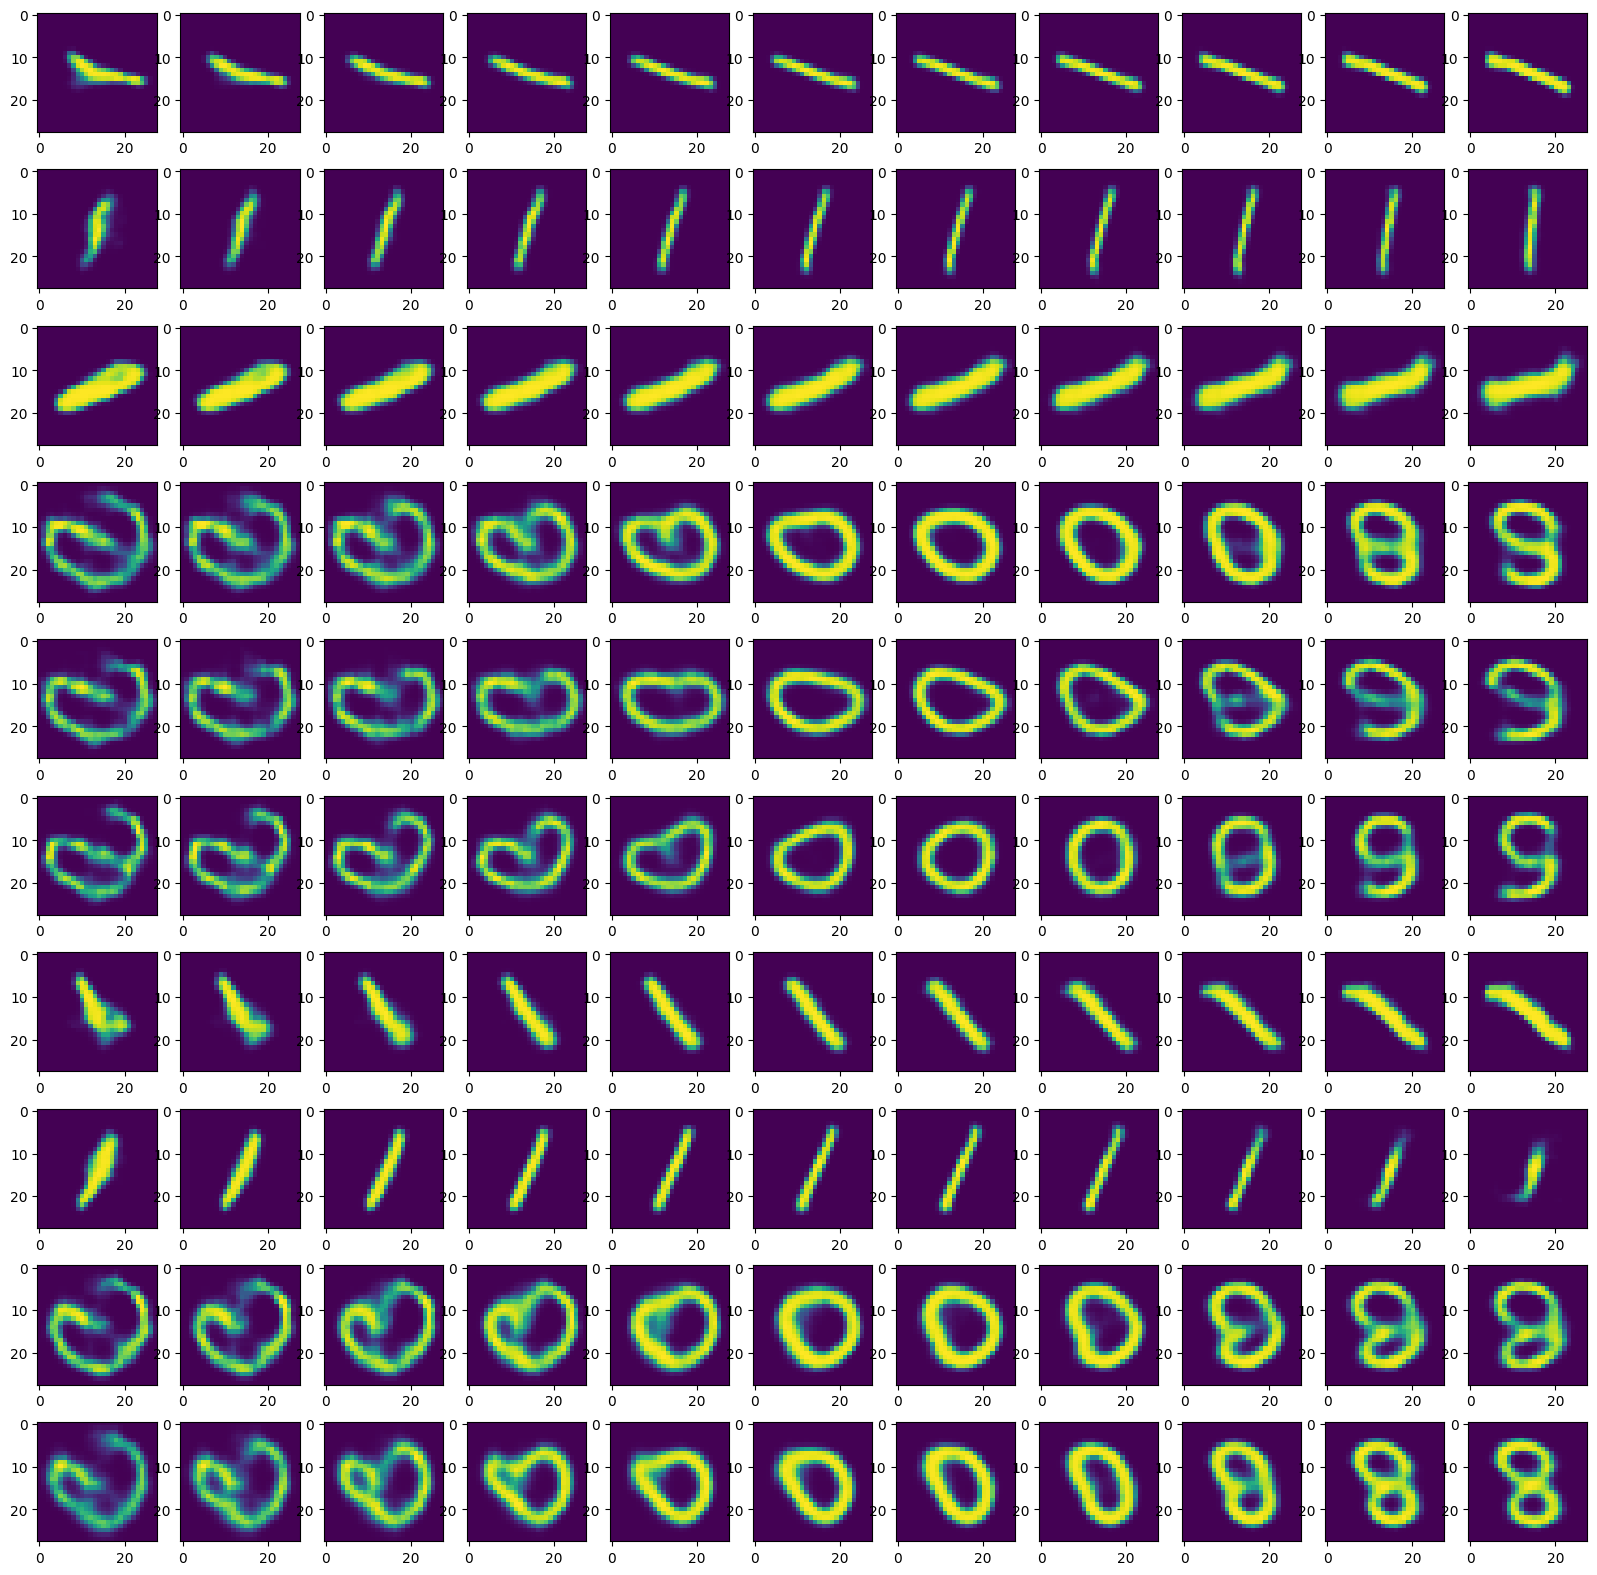

In [78]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero,zero,zero,zero,zero,zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

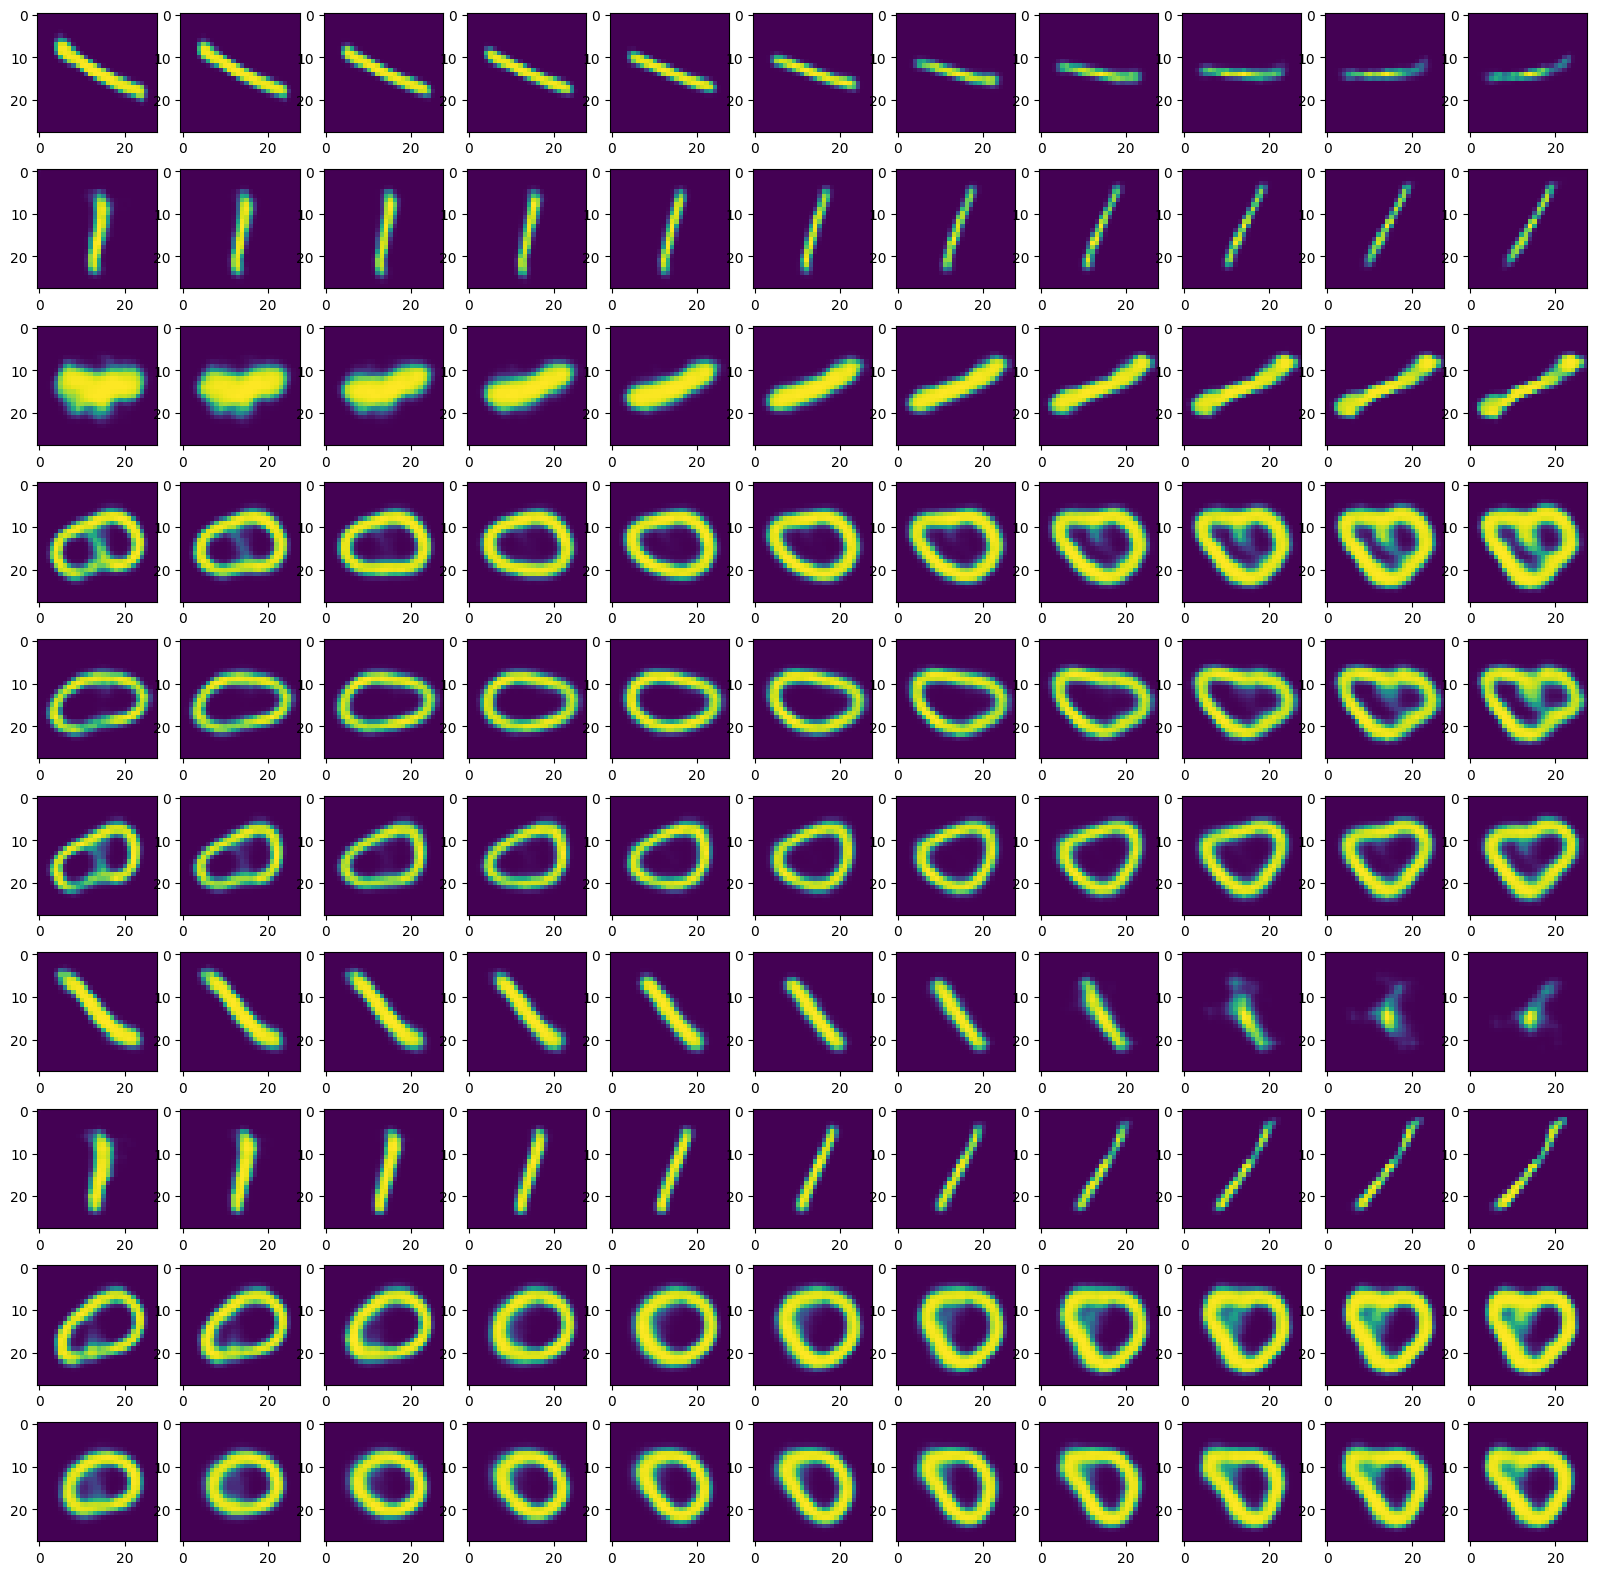

In [79]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero,zero,zero,zero,zero,zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

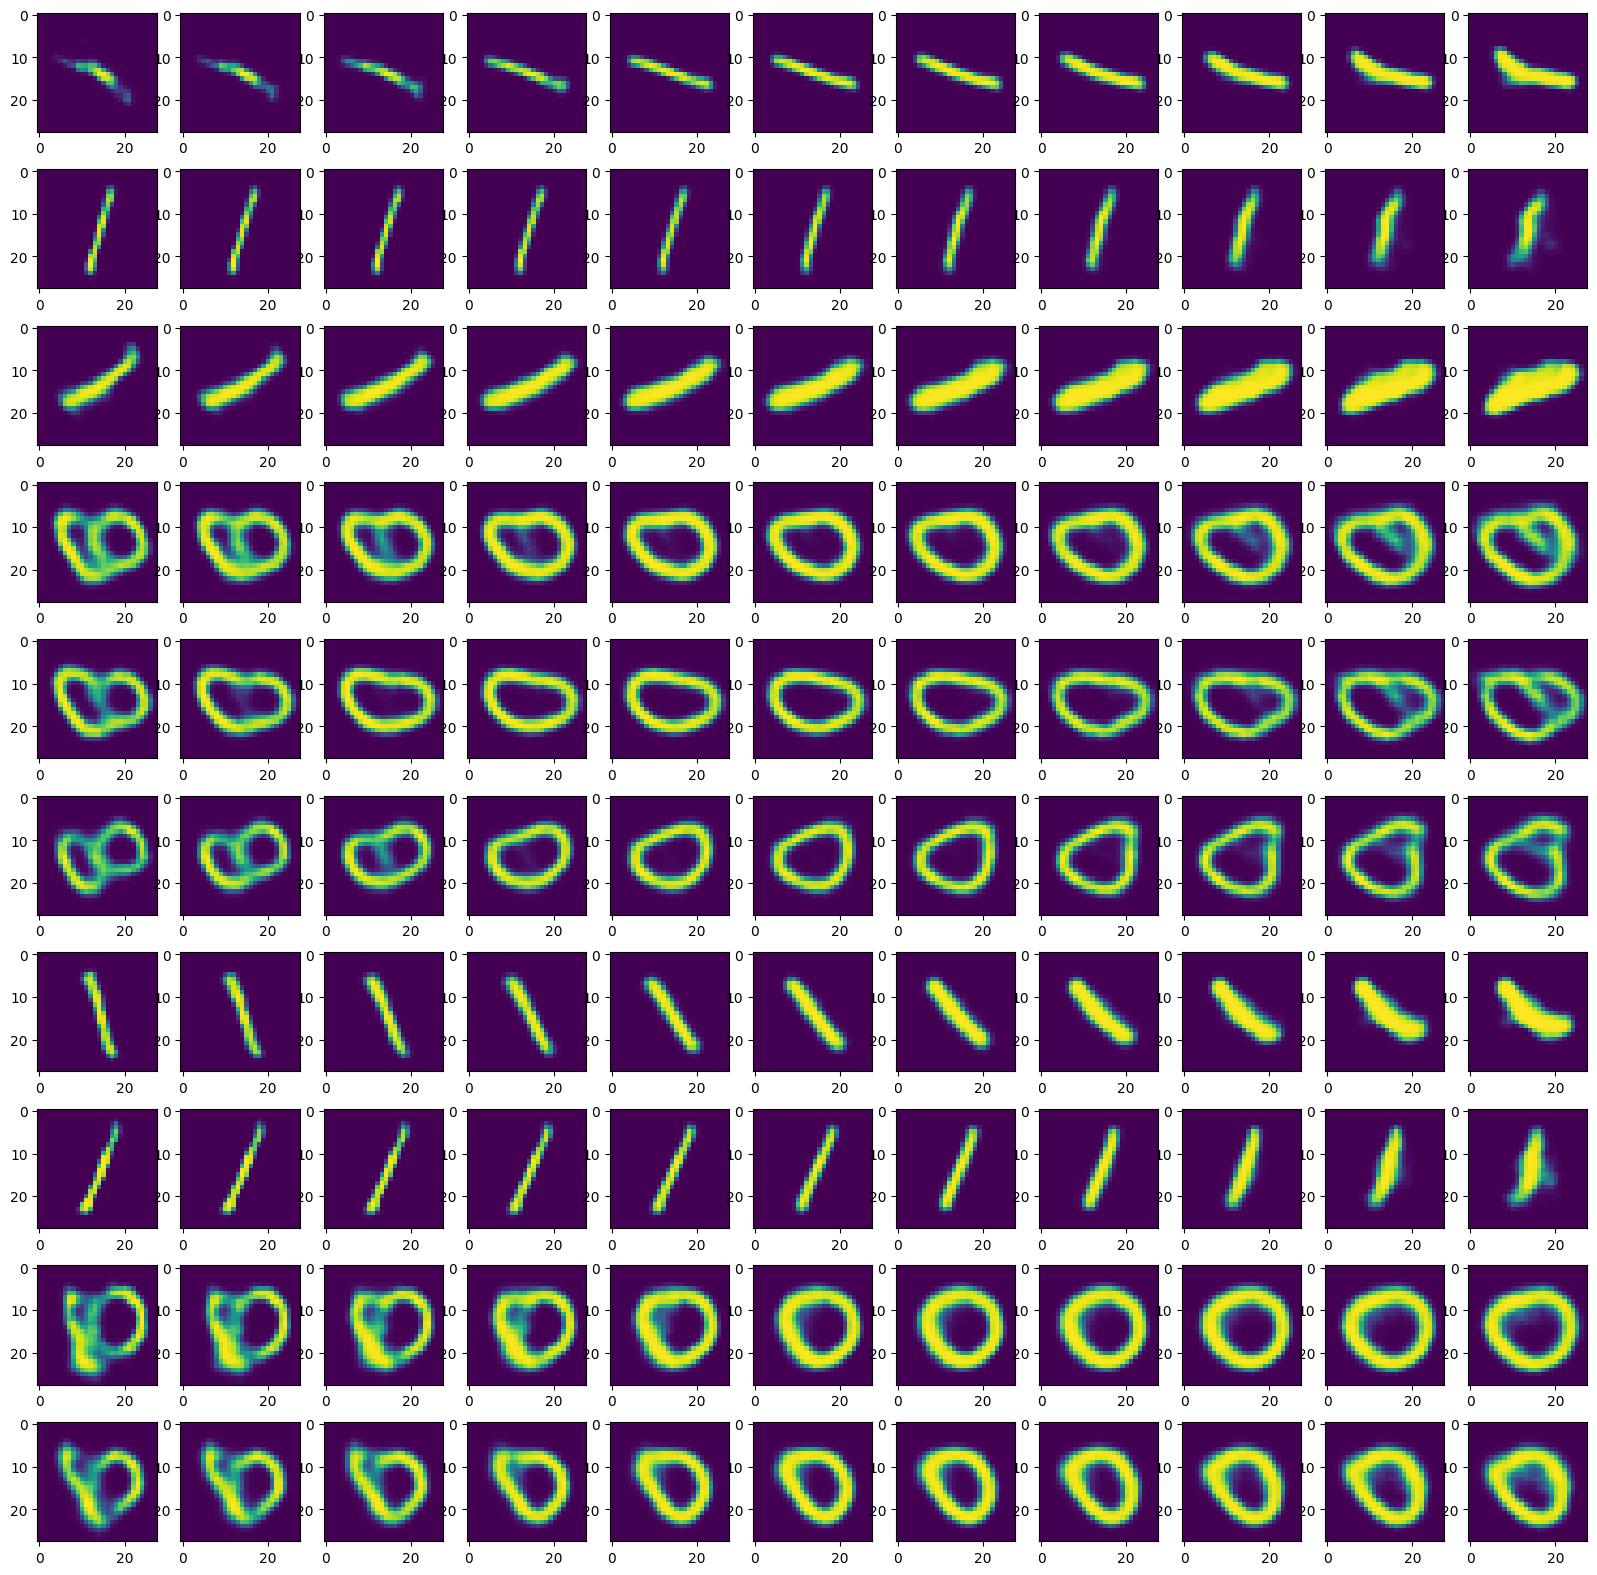

In [80]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step),zero,zero,zero,zero,zero,zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

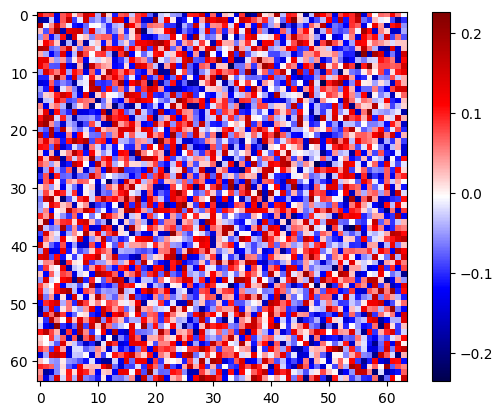

In [81]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

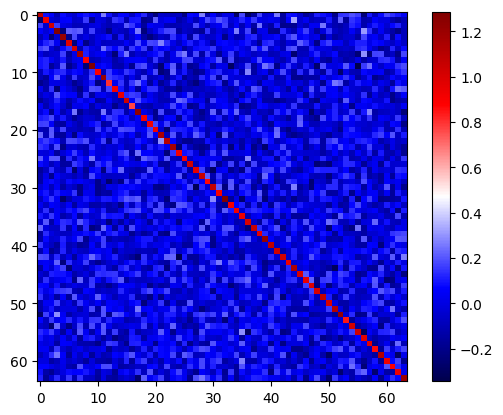

In [82]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

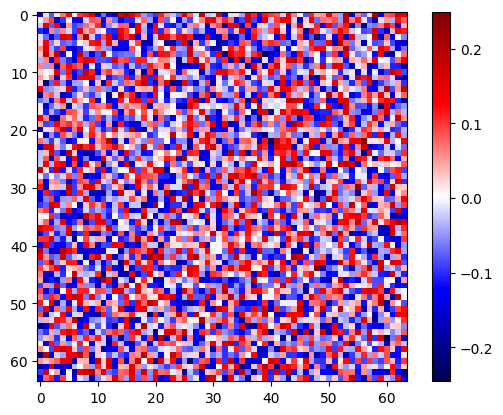

In [94]:
plt.imshow(model_symmetry.group[9].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

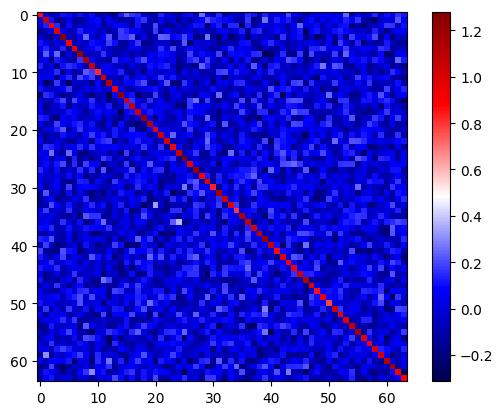

In [93]:
plt.imshow(torch.matrix_exp(model_symmetry.group[9].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

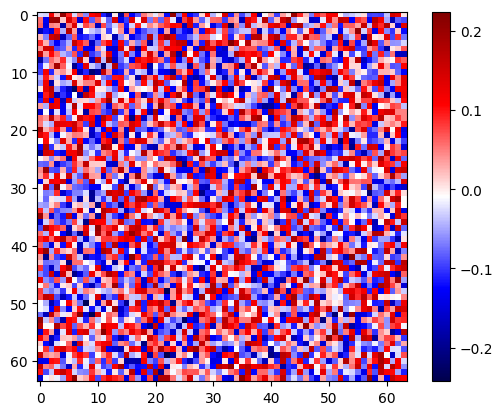

In [85]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

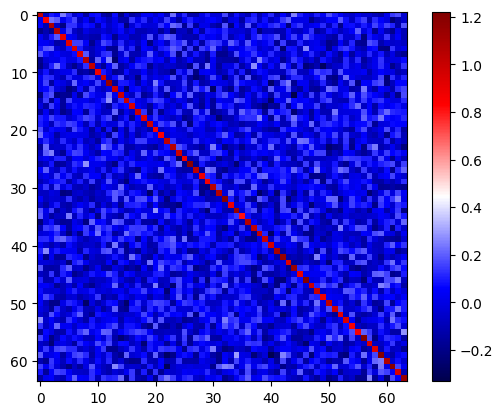

In [86]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()